# Label Studio json to COCO conversion

In [1]:
import json
import itertools
import cv2
import os

In [2]:
DATA_DIR = './train'
annotations = []
images = []
with open('labels/data.json') as f:
    d = json.load(f)
    for i, obj in enumerate(d):
        filename = obj['file_upload'].split('-', 1)[1]
        if not os.path.isfile(os.path.join(DATA_DIR, filename)):
            continue
        im = cv2.imread(os.path.join(DATA_DIR, filename))
        height, width, channels = im.shape
        
        image = {'id': i, 'file_name': filename, 'height': height, 'width': width}
        
        annotation = {'id':i, 'image_id':i, 'num_keypoints': 4, "category_id": 1}
        keypoints = {'left_sleeve_1': [],'left_sleeve_2': [],'right_sleeve_1': [],'right_sleeve_2': []}
        for result in obj['annotations'][0]['result']:
            value = result['value']
            if result['type'] =='rectanglelabels':
                annotation['bbox'] = [round(value['x']/ 100.0 * width), round(value['y']/ 100.0 * height), round(value['width']/ 100.0 * width), round(value['height']/ 100.0 * height)]
            else:
                keypoints[value['keypointlabels'][0]] = [round(value['x']/ 100.0 * width), round(value['y']/ 100.0 * height), 2]
        annotation['keypoints'] = list(itertools.chain(*keypoints.values()))
        annotations.append(annotation)
        images.append(image)
        
categories = [{'id': 1, 'name': 'shirt', 'keypoints': ['left_sleeve_1', 'left_sleeve_2', 'right_sleeve_1', 'right_sleeve_2']}]
        
final_annotations = {'images': images, 'annotations': annotations, 'categories':categories}
with open('labels/data_coco.json', 'w') as f:
    json.dump(final_annotations, f)

# Training with Detectron2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import some common libraries
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.logger import setup_logger

from detectron2.data import (MetadataCatalog,
                             build_detection_train_loader,
                             build_detection_test_loader,
                             DatasetMapper, transforms as T,
                             detection_utils as utils)
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
from detectron2.data.datasets import register_coco_instances
#register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
register_coco_instances("shirt_train", {}, "labels/data_coco.json", "train")

keypoint_names = ['left_sleeve_1', 'left_sleeve_2', 'right_sleeve_1', 'right_sleeve_2']
keypoint_flip_map = [('left_sleeve_1', 'right_sleeve_1'), ('left_sleeve_2', 'right_sleeve_2')]

from detectron2.data import MetadataCatalog
classes = MetadataCatalog.get("shirt_train").thing_classes = ["shirt"]
print(classes)

MetadataCatalog.get("shirt_train").thing_classes = ["shirt"]
MetadataCatalog.get("shirt_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("shirt_train").keypoint_names = keypoint_names
MetadataCatalog.get("shirt_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("shirt_train").evaluator_type="coco"

['shirt']


[10/14 13:43:42 d2.data.datasets.coco]: Loaded 114 images in COCO format from labels/data_coco.json
Showing train/16281300002e2414f5d5042e8f1614081360e488a8_thumbnail_405x552.jpg
Showing train/1622088248004895fe7ce1ca5bb6fb4e79c5363f7d_thumbnail_405x552.jpg
Showing train/15868790068a5f28d3daa1d14eaa7a41f7140c0e7b_thumbnail_405x552.jpg
Showing train/1630393693afcf9a38c6ac36aaa82526b800adf0d3_thumbnail_405x552.jpg
Showing train/16111245281cb7b1f87af39750dfce244cdbed809f_thumbnail_405x552.jpg


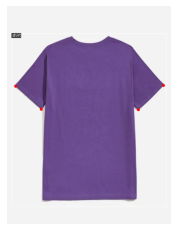

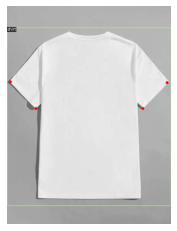

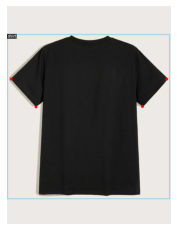

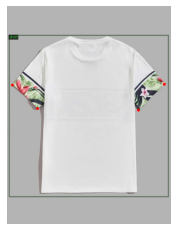

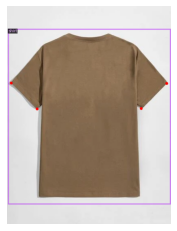

In [5]:
import random
from detectron2.utils.visualizer import Visualizer
dataset_dicts = DatasetCatalog.get("shirt_train")
hands_metadata = MetadataCatalog.get("shirt_train")
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');
    
for d in random.sample(dataset_dicts, 5):
    print("Showing " + d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=1)   
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [6]:
from detectron2.engine import DefaultTrainer
from typing import List, Optional, Union


class Trainer(DefaultTrainer):
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        is_train = True
        augs = utils.build_augmentation(cfg, is_train)
        augs.append(T.RandomBrightness(intensity_min=0.75, intensity_max=1.25))
        augs.append(T.RandomContrast(intensity_min=0.76, intensity_max=1.25))
        augs.append(T.RandomSaturation(intensity_min=0.75, intensity_max=1.25))
        if cfg.INPUT.CROP.ENABLED and is_train:
            augs.insert(0, T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE))
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True, augmentations= augs))

In [7]:
# Configs
EPOCHS = 10
BATCH_SIZE = 2

train_dataset_dicts = DatasetCatalog.get("shirt_train")

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("shirt_train",)

cfg.DATASETS.TEST = ()  #Dataset 'bat_test' is empty 
#cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.SOLVER.BASE_LR = 0.0008  # pick a good LR
cfg.SOLVER.MAX_ITER = len(train_dataset_dicts) // BATCH_SIZE * EPOCHS   # MAX_ITER = total images / batch size * epochs
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # bat
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = len(keypoint_names)
cfg.TEST.KEYPOINT_OKS_SIGMAS = tuple(np.ones(len(keypoint_names), dtype=float).tolist())

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

[10/14 13:43:43 d2.data.datasets.coco]: Loaded 114 images in COCO format from labels/data_coco.json


In [8]:

trainer = Trainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
print("Done!")

[10/14 13:43:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 4, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[10/14 13:43:50 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:983.)
  num_fg = fg_inds.nonzero().numel()


[10/14 13:44:02 d2.utils.events]:  eta: 0:04:09  iter: 19  total_loss: 8.463  loss_cls: 0.2957  loss_box_reg: 0.07699  loss_keypoint: 7.963  loss_rpn_cls: 0.04175  loss_rpn_loc: 0.02525  time: 0.4556  data_time: 0.0157  lr: 2.744e-05  max_mem: 3402M
[10/14 13:44:10 d2.utils.events]:  eta: 0:03:55  iter: 39  total_loss: 7.801  loss_cls: 0.02261  loss_box_reg: 0.03942  loss_keypoint: 7.718  loss_rpn_cls: 0.005916  loss_rpn_loc: 0.01495  time: 0.4446  data_time: 0.0050  lr: 5.5482e-05  max_mem: 3402M
[10/14 13:44:19 d2.utils.events]:  eta: 0:03:46  iter: 59  total_loss: 6.333  loss_cls: 0.01524  loss_box_reg: 0.02834  loss_keypoint: 6.286  loss_rpn_cls: 0.004564  loss_rpn_loc: 0.01638  time: 0.4454  data_time: 0.0050  lr: 8.3524e-05  max_mem: 3402M
[10/14 13:44:28 d2.utils.events]:  eta: 0:03:37  iter: 79  total_loss: 3.925  loss_cls: 0.01338  loss_box_reg: 0.03179  loss_keypoint: 3.867  loss_rpn_cls: 0.004714  loss_rpn_loc: 0.0153  time: 0.4448  data_time: 0.0048  lr: 0.00011157  max_mem

Showing train/162426807772c87f9c13b671cc53a61f5d42b6ebe6_thumbnail_405x552.jpg


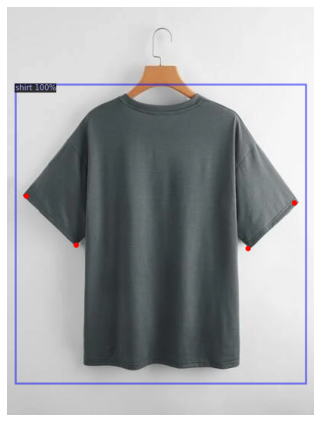

Showing train/15850206067f12731adf0d5b84296dddb084ebfb10_thumbnail_405x552.jpg


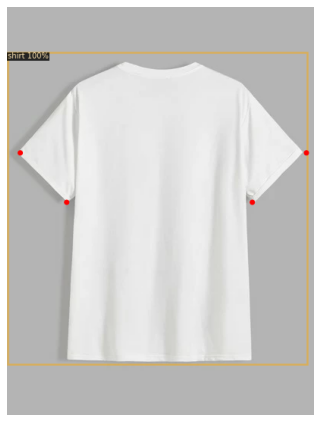

Showing train/16287387018f8a69373fb602220b0a60394fc3be6f_thumbnail_405x552.jpg


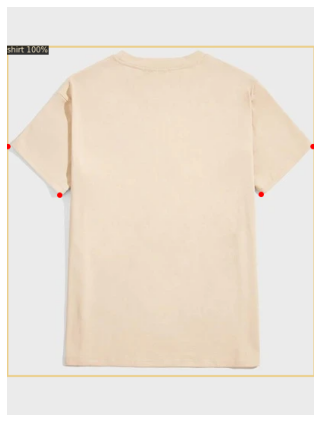

Showing train/1631092745fe0a5d6bc019eb15f6c547b434b9fbd6_thumbnail_405x552.jpg


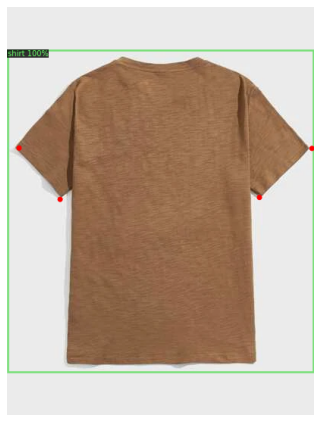

Showing train/16282220313e7bbcfac84fff031eb46cfd49cd953f_thumbnail_405x552.jpg


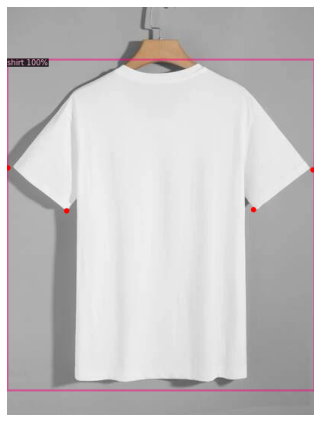

In [9]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');
    plt.show()
    
for d in random.sample(dataset_dicts, 5):
    print("Showing " + d['file_name'])
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=1)    # remove the colors of unsegmented pixels
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    cv2_imshow(v.get_image()[:, :, ::-1])

